In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime


# Custom modules and packages
import params.siamese
import traversalcost.utils
from dataset import SiameseNetworkDataset
from model import SiameseNetwork
from loss import SiameseLoss
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.siamese.LEARNING

## Prepare data

In [3]:
# Create a Dataset for training
train_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for testing
test_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_test.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Set the train dataset size
train_size = params.siamese.TRAIN_SIZE/(1-params.siamese.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [4]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [5]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (302 samples)
15.0 % of the data for validation (65 samples)
15.0 % of the data for testing (65 samples)


## GPU?

In [6]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [7]:
# Create a model
nb_input_features = len(train_set[0][0])
model = SiameseNetwork(input_size=nb_input_features).to(device=device)

In [8]:
# Create a loss function
criterion = SiameseLoss(margin=LEARNING_PARAMS["margin"]).to(device=device)

In [9]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the accuracy values
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy = train(model,
                                       device,
                                       train_loader,
                                       optimizer,
                                       criterion,
                                       epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model,
                                      device,
                                      val_loader,
                                      criterion,
                                      epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy

Epoch 0 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.14batch/s, batch_loss=0.15] 


Train loss:  0.14910832831734105
Validation loss:  0.1436226252052519
Train accuracy:  52.317880794701985
Validation accuracy:  67.6923076923077


Epoch 1 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.39batch/s, batch_loss=0.15] 


Train loss:  0.14515279743232226
Validation loss:  0.1390101040403048
Train accuracy:  61.258278145695364
Validation accuracy:  60.0


Epoch 2 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.10batch/s, batch_loss=0.148]


Train loss:  0.1409334946227701
Validation loss:  0.13417747451199424
Train accuracy:  64.56953642384106
Validation accuracy:  67.6923076923077


Epoch 3 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.32batch/s, batch_loss=0.145] 


Train loss:  0.13539297055256994
Validation loss:  0.12612393663989174
Train accuracy:  67.54966887417218
Validation accuracy:  70.76923076923077


Epoch 4 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.90batch/s, batch_loss=0.151]


Train loss:  0.12764670366519376
Validation loss:  0.1212662077612347
Train accuracy:  69.86754966887418
Validation accuracy:  70.76923076923077


Epoch 5 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.33batch/s, batch_loss=0.000745]


Train loss:  0.11811686954215954
Validation loss:  0.10328289618094762
Train accuracy:  73.17880794701986
Validation accuracy:  75.38461538461539


Epoch 6 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.50batch/s, batch_loss=0.0806]


Train loss:  0.10660855864223681
Validation loss:  0.10711244824859831
Train accuracy:  79.47019867549669
Validation accuracy:  76.92307692307692


Epoch 7 [val]: 100%|██████████| 9/9 [00:00<00:00, 11.50batch/s, batch_loss=0.142] 


Train loss:  0.0971292736695001
Validation loss:  0.11039849826031262
Train accuracy:  78.1456953642384
Validation accuracy:  76.92307692307692


Epoch 8 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.01batch/s, batch_loss=0.149] 


Train loss:  0.08812251392948
Validation loss:  0.10473930421802732
Train accuracy:  80.79470198675497
Validation accuracy:  75.38461538461539


Epoch 9 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.97batch/s, batch_loss=0.147] 


Train loss:  0.08012344727390691
Validation loss:  0.09886946611934239
Train accuracy:  83.44370860927152
Validation accuracy:  76.92307692307692


Epoch 10 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.35batch/s, batch_loss=0.159] 


Train loss:  0.07442428470638238
Validation loss:  0.09803473701079686
Train accuracy:  83.11258278145695
Validation accuracy:  76.92307692307692


Epoch 11 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.13batch/s, batch_loss=0]     


Train loss:  0.07025460251852085
Validation loss:  0.08066917003856765
Train accuracy:  83.11258278145695
Validation accuracy:  73.84615384615384


Epoch 12 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.43batch/s, batch_loss=0.144] 


Train loss:  0.06588819760241006
Validation loss:  0.09526260942220688
Train accuracy:  84.76821192052981
Validation accuracy:  80.0


Epoch 13 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.41batch/s, batch_loss=0.234] 


Train loss:  0.06402030052911294
Validation loss:  0.1009591134885947
Train accuracy:  85.43046357615894
Validation accuracy:  80.0


Epoch 14 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.24batch/s, batch_loss=0.216] 


Train loss:  0.06191548391392356
Validation loss:  0.10094503975576824
Train accuracy:  85.09933774834437
Validation accuracy:  75.38461538461539


Epoch 15 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.58batch/s, batch_loss=0]     


Train loss:  0.06048733456746528
Validation loss:  0.0778522930211491
Train accuracy:  85.09933774834437
Validation accuracy:  75.38461538461539


Epoch 16 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.52batch/s, batch_loss=0.00031]


Train loss:  0.059576413054999555
Validation loss:  0.07927755949397881
Train accuracy:  84.43708609271523
Validation accuracy:  73.84615384615384


Epoch 17 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.21batch/s, batch_loss=0.0059]


Train loss:  0.0580511906331307
Validation loss:  0.07861663442518976
Train accuracy:  83.7748344370861
Validation accuracy:  75.38461538461539


Epoch 18 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.18batch/s, batch_loss=0.216] 


Train loss:  0.05679373477438563
Validation loss:  0.09759609649578731
Train accuracy:  84.43708609271523
Validation accuracy:  75.38461538461539


Epoch 19 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.07batch/s, batch_loss=0.0105]


Train loss:  0.057353901333714784
Validation loss:  0.0788465469247765
Train accuracy:  85.09933774834437
Validation accuracy:  75.38461538461539


Epoch 20 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.35batch/s, batch_loss=0]     


Train loss:  0.05542408493592551
Validation loss:  0.07815030879444546
Train accuracy:  84.43708609271523
Validation accuracy:  73.84615384615384


Epoch 21 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.38batch/s, batch_loss=0]     


Train loss:  0.055634187289366595
Validation loss:  0.07763661526971394
Train accuracy:  84.10596026490066
Validation accuracy:  73.84615384615384


Epoch 22 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.98batch/s, batch_loss=0]     


Train loss:  0.05383844163857008
Validation loss:  0.07461104542016983
Train accuracy:  85.09933774834437
Validation accuracy:  75.38461538461539


Epoch 23 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.46batch/s, batch_loss=0.159] 


Train loss:  0.05375196618077002
Validation loss:  0.08958828076720238
Train accuracy:  85.43046357615894
Validation accuracy:  75.38461538461539


Epoch 24 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.71batch/s, batch_loss=0]     


Train loss:  0.053025067195688426
Validation loss:  0.07376839593052864
Train accuracy:  84.76821192052981
Validation accuracy:  76.92307692307692


Epoch 25 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.11batch/s, batch_loss=0.0702]


Train loss:  0.05228787209642561
Validation loss:  0.08361903060641554
Train accuracy:  86.42384105960265
Validation accuracy:  76.92307692307692


Epoch 26 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.38batch/s, batch_loss=0]     


Train loss:  0.05219962384159628
Validation loss:  0.07107619879146417
Train accuracy:  87.41721854304636
Validation accuracy:  81.53846153846153


Epoch 27 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.41batch/s, batch_loss=0.0593]


Train loss:  0.05275469405674621
Validation loss:  0.0781228155311611
Train accuracy:  85.76158940397352
Validation accuracy:  76.92307692307692


Epoch 28 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.11batch/s, batch_loss=0]     


Train loss:  0.05267900414764881
Validation loss:  0.07292166497144434
Train accuracy:  86.09271523178808
Validation accuracy:  76.92307692307692


Epoch 29 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.54batch/s, batch_loss=0.31]  


Train loss:  0.05291257445749484
Validation loss:  0.1007688662244214
Train accuracy:  85.76158940397352
Validation accuracy:  76.92307692307692


Epoch 30 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.64batch/s, batch_loss=0.0434]


Train loss:  0.0527979863905593
Validation loss:  0.0768563561141491
Train accuracy:  85.76158940397352
Validation accuracy:  76.92307692307692


Epoch 31 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.58batch/s, batch_loss=0.0739]


Train loss:  0.05226428414645948
Validation loss:  0.0784364930457539
Train accuracy:  85.76158940397352
Validation accuracy:  76.92307692307692


Epoch 32 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.17batch/s, batch_loss=0]     


Train loss:  0.050715226336921514
Validation loss:  0.06953270898924933
Train accuracy:  86.09271523178808
Validation accuracy:  76.92307692307692


Epoch 33 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.87batch/s, batch_loss=0]     


Train loss:  0.051302456198946425
Validation loss:  0.07004234608676699
Train accuracy:  85.76158940397352
Validation accuracy:  76.92307692307692


Epoch 34 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.20batch/s, batch_loss=0.0947]


Train loss:  0.05121133059851433
Validation loss:  0.08226564940479067
Train accuracy:  86.09271523178808
Validation accuracy:  76.92307692307692


Epoch 35 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.13batch/s, batch_loss=0.0419]


Train loss:  0.04965298318941342
Validation loss:  0.0719585737420453
Train accuracy:  86.42384105960265
Validation accuracy:  81.53846153846153


Epoch 36 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.21batch/s, batch_loss=0.179] 


Train loss:  0.04988353998449288
Validation loss:  0.08680854654974407
Train accuracy:  87.08609271523179
Validation accuracy:  78.46153846153847


Epoch 37 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.44batch/s, batch_loss=0.126] 


Train loss:  0.050202889564005954
Validation loss:  0.08302956322828929
Train accuracy:  87.08609271523179
Validation accuracy:  80.0


Epoch 38 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.51batch/s, batch_loss=0.124] 


Train loss:  0.049253914652294235
Validation loss:  0.08127438214917977
Train accuracy:  86.42384105960265
Validation accuracy:  78.46153846153847


Epoch 39 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.11batch/s, batch_loss=0]     


Train loss:  0.048169113597587535
Validation loss:  0.07132850049270524
Train accuracy:  87.41721854304636
Validation accuracy:  78.46153846153847


Epoch 40 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.45batch/s, batch_loss=0]     


Train loss:  0.048504449231059926
Validation loss:  0.0662525828099913
Train accuracy:  86.75496688741723
Validation accuracy:  78.46153846153847


Epoch 41 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.50batch/s, batch_loss=0.0951]


Train loss:  0.048815920801931305
Validation loss:  0.07416434834400813
Train accuracy:  86.75496688741723
Validation accuracy:  78.46153846153847


Epoch 42 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.28batch/s, batch_loss=0.121] 


Train loss:  0.04764707675693851
Validation loss:  0.08352380742629369
Train accuracy:  88.0794701986755
Validation accuracy:  76.92307692307692


Epoch 43 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.50batch/s, batch_loss=0]     


Train loss:  0.04879170523858384
Validation loss:  0.06506169401109219
Train accuracy:  87.08609271523179
Validation accuracy:  84.61538461538461


Epoch 44 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.81batch/s, batch_loss=0]     


Train loss:  0.049541233646634375
Validation loss:  0.06606016639206144
Train accuracy:  88.74172185430463
Validation accuracy:  80.0


Epoch 45 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.50batch/s, batch_loss=0]     


Train loss:  0.04637682754056234
Validation loss:  0.06568172718915674
Train accuracy:  87.74834437086092
Validation accuracy:  78.46153846153847


Epoch 46 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.22batch/s, batch_loss=0]     


Train loss:  0.049147940730970154
Validation loss:  0.07103993329736921
Train accuracy:  86.75496688741723
Validation accuracy:  78.46153846153847


Epoch 47 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.79batch/s, batch_loss=0.147] 


Train loss:  0.04759653299850853
Validation loss:  0.0778615220139424
Train accuracy:  87.41721854304636
Validation accuracy:  84.61538461538461


Epoch 48 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.96batch/s, batch_loss=0.183] 


Train loss:  0.04679214238728348
Validation loss:  0.08064819168713358
Train accuracy:  88.74172185430463
Validation accuracy:  83.07692307692308


Epoch 49 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.45batch/s, batch_loss=0]     


Train loss:  0.04687151489289183
Validation loss:  0.06650804686877462
Train accuracy:  87.74834437086092
Validation accuracy:  80.0


Epoch 50 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.49batch/s, batch_loss=0.0371]


Train loss:  0.04628165326032199
Validation loss:  0.06883564094702403
Train accuracy:  88.0794701986755
Validation accuracy:  80.0


Epoch 51 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.29batch/s, batch_loss=0]     


Train loss:  0.04527984432091838
Validation loss:  0.064702733937237
Train accuracy:  87.41721854304636
Validation accuracy:  78.46153846153847


Epoch 52 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.14batch/s, batch_loss=0.271] 


Train loss:  0.04548328556120396
Validation loss:  0.0870875476135148
Train accuracy:  87.74834437086092
Validation accuracy:  86.15384615384616


Epoch 53 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.78batch/s, batch_loss=0]     


Train loss:  0.046269102953374386
Validation loss:  0.06060011084708902
Train accuracy:  87.41721854304636
Validation accuracy:  84.61538461538461


Epoch 54 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.48batch/s, batch_loss=0]     


Train loss:  0.04529035316878244
Validation loss:  0.06005874607298109
Train accuracy:  88.0794701986755
Validation accuracy:  86.15384615384616


Epoch 55 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.47batch/s, batch_loss=0]     


Train loss:  0.04526909470166031
Validation loss:  0.05821140151884821
Train accuracy:  89.73509933774834
Validation accuracy:  87.6923076923077


Epoch 56 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.34batch/s, batch_loss=0]     


Train loss:  0.04844644763752034
Validation loss:  0.06838902210195859
Train accuracy:  87.41721854304636
Validation accuracy:  81.53846153846153


Epoch 57 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.91batch/s, batch_loss=0.0674]


Train loss:  0.04536765789319026
Validation loss:  0.06475374061200354
Train accuracy:  87.74834437086092
Validation accuracy:  83.07692307692308


Epoch 58 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.06batch/s, batch_loss=0]     


Train loss:  0.043718839113257434
Validation loss:  0.05811424512002203
Train accuracy:  88.41059602649007
Validation accuracy:  87.6923076923077


Epoch 59 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.32batch/s, batch_loss=0]     


Train loss:  0.04478758806362748
Validation loss:  0.05701384445031484
Train accuracy:  88.41059602649007
Validation accuracy:  87.6923076923077


Epoch 60 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.45batch/s, batch_loss=0]     


Train loss:  0.04314884528713791
Validation loss:  0.06609081559711033
Train accuracy:  88.41059602649007
Validation accuracy:  81.53846153846153


Epoch 61 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.24batch/s, batch_loss=0]     


Train loss:  0.043844001710807025
Validation loss:  0.06124429052902593
Train accuracy:  87.74834437086092
Validation accuracy:  83.07692307692308


Epoch 62 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.37batch/s, batch_loss=0]     


Train loss:  0.043035941835688915
Validation loss:  0.06031787788702382
Train accuracy:  89.40397350993378
Validation accuracy:  86.15384615384616


Epoch 63 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.23batch/s, batch_loss=0]     


Train loss:  0.04252252389529818
Validation loss:  0.058381016469664045
Train accuracy:  88.41059602649007
Validation accuracy:  86.15384615384616


Epoch 64 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.48batch/s, batch_loss=0.027] 


Train loss:  0.042389984193601106
Validation loss:  0.06298860162496567
Train accuracy:  89.40397350993378
Validation accuracy:  84.61538461538461


Epoch 65 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.29batch/s, batch_loss=0]     


Train loss:  0.04169442244854413
Validation loss:  0.0603974892033471
Train accuracy:  89.73509933774834
Validation accuracy:  81.53846153846153


Epoch 66 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.26batch/s, batch_loss=0]     


Train loss:  0.044447232380901515
Validation loss:  0.06166553787059254
Train accuracy:  89.40397350993378
Validation accuracy:  81.53846153846153


Epoch 67 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.04batch/s, batch_loss=0.0984]


Train loss:  0.04458374383026048
Validation loss:  0.06994168667329682
Train accuracy:  88.41059602649007
Validation accuracy:  83.07692307692308


Epoch 68 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.58batch/s, batch_loss=0.173] 


Train loss:  0.04015703107181348
Validation loss:  0.06922123684651321
Train accuracy:  89.73509933774834
Validation accuracy:  89.23076923076923


Epoch 69 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.54batch/s, batch_loss=0]     


Train loss:  0.04044241389553798
Validation loss:  0.051029021127356425
Train accuracy:  90.06622516556291
Validation accuracy:  89.23076923076923


Epoch 70 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.73batch/s, batch_loss=0]     


Train loss:  0.03998682393055213
Validation loss:  0.06616402417421341
Train accuracy:  89.73509933774834
Validation accuracy:  80.0


Epoch 71 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.14batch/s, batch_loss=0]     


Train loss:  0.038902136056046734
Validation loss:  0.05302220686442322
Train accuracy:  90.06622516556291
Validation accuracy:  89.23076923076923


Epoch 72 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.82batch/s, batch_loss=0]     


Train loss:  0.040491144761051
Validation loss:  0.055781105533242226
Train accuracy:  90.06622516556291
Validation accuracy:  86.15384615384616


Epoch 73 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.69batch/s, batch_loss=0]     


Train loss:  0.041329316990940196
Validation loss:  0.054669953882694244
Train accuracy:  89.73509933774834
Validation accuracy:  86.15384615384616


Epoch 74 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.38batch/s, batch_loss=0]     


Train loss:  0.04343952861075338
Validation loss:  0.05743099417951372
Train accuracy:  89.40397350993378
Validation accuracy:  87.6923076923077


Epoch 75 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.22batch/s, batch_loss=0]     


Train loss:  0.04081227860756611
Validation loss:  0.05466181826260355
Train accuracy:  90.06622516556291
Validation accuracy:  87.6923076923077


Epoch 76 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.00batch/s, batch_loss=0]     


Train loss:  0.041430962713141194
Validation loss:  0.06205070349905226
Train accuracy:  90.39735099337749
Validation accuracy:  78.46153846153847


Epoch 77 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.19batch/s, batch_loss=0]     


Train loss:  0.03855971844964906
Validation loss:  0.049921746055285134
Train accuracy:  89.73509933774834
Validation accuracy:  89.23076923076923


Epoch 78 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.04batch/s, batch_loss=0.00312]


Train loss:  0.03882350944178669
Validation loss:  0.051603525049156614
Train accuracy:  90.06622516556291
Validation accuracy:  89.23076923076923


Epoch 79 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.70batch/s, batch_loss=0]      


Train loss:  0.03669722324335262
Validation loss:  0.05298927550514539
Train accuracy:  90.06622516556291
Validation accuracy:  86.15384615384616


Epoch 80 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.38batch/s, batch_loss=0]     


Train loss:  0.03964122237735673
Validation loss:  0.05488710726300875
Train accuracy:  89.73509933774834
Validation accuracy:  87.6923076923077


Epoch 81 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.52batch/s, batch_loss=0.0747]


Train loss:  0.038312239327320925
Validation loss:  0.056134245875808925
Train accuracy:  90.06622516556291
Validation accuracy:  89.23076923076923


Epoch 82 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.32batch/s, batch_loss=0]     


Train loss:  0.03796361484809926
Validation loss:  0.05510710241893927
Train accuracy:  90.39735099337749
Validation accuracy:  83.07692307692308


Epoch 83 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.19batch/s, batch_loss=0.0542] 


Train loss:  0.03532785750729473
Validation loss:  0.05181767294804255
Train accuracy:  91.72185430463576
Validation accuracy:  87.6923076923077


Epoch 84 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.31batch/s, batch_loss=0.183] 


Train loss:  0.04136237497196386
Validation loss:  0.08415983203384611
Train accuracy:  88.41059602649007
Validation accuracy:  81.53846153846153


Epoch 85 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.28batch/s, batch_loss=0]     


Train loss:  0.040589772409906515
Validation loss:  0.05768947448167536
Train accuracy:  89.0728476821192
Validation accuracy:  83.07692307692308


Epoch 86 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.35batch/s, batch_loss=0.0846]


Train loss:  0.037490227406746464
Validation loss:  0.059773569719658956
Train accuracy:  90.39735099337749
Validation accuracy:  89.23076923076923


Epoch 87 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.59batch/s, batch_loss=0.0195]


Train loss:  0.03875808099186734
Validation loss:  0.05368598674734434
Train accuracy:  89.40397350993378
Validation accuracy:  89.23076923076923


Epoch 88 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.47batch/s, batch_loss=0.27]  


Train loss:  0.03981485117324873
Validation loss:  0.0790940448641777
Train accuracy:  89.73509933774834
Validation accuracy:  89.23076923076923


Epoch 89 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.36batch/s, batch_loss=0]     


Train loss:  0.04225848884762902
Validation loss:  0.055078893072075315
Train accuracy:  89.0728476821192
Validation accuracy:  86.15384615384616


Epoch 90 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.76batch/s, batch_loss=0.179] 


Train loss:  0.039847103290651976
Validation loss:  0.07293814130955273
Train accuracy:  89.0728476821192
Validation accuracy:  86.15384615384616


Epoch 91 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.30batch/s, batch_loss=0.194] 


Train loss:  0.038637060623027776
Validation loss:  0.0789310952855481
Train accuracy:  89.40397350993378
Validation accuracy:  81.53846153846153


Epoch 92 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.37batch/s, batch_loss=0]      


Train loss:  0.03762136978146277
Validation loss:  0.051788667423857584
Train accuracy:  89.40397350993378
Validation accuracy:  87.6923076923077


Epoch 93 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.32batch/s, batch_loss=0]      


Train loss:  0.03474737850851134
Validation loss:  0.05301255277461476
Train accuracy:  90.72847682119205
Validation accuracy:  86.15384615384616


Epoch 94 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.12batch/s, batch_loss=0.0435] 


Train loss:  0.033448491784694945
Validation loss:  0.05899135727021429
Train accuracy:  91.05960264900662
Validation accuracy:  86.15384615384616


Epoch 95 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.55batch/s, batch_loss=0]     


Train loss:  0.036200033745875486
Validation loss:  0.055204772700866066
Train accuracy:  90.72847682119205
Validation accuracy:  87.6923076923077


Epoch 96 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.98batch/s, batch_loss=0.0909]


Train loss:  0.03659395510820966
Validation loss:  0.05588998252318965
Train accuracy:  90.72847682119205
Validation accuracy:  89.23076923076923


Epoch 97 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.31batch/s, batch_loss=0]     


Train loss:  0.033496481783099864
Validation loss:  0.056922829813427396
Train accuracy:  90.72847682119205
Validation accuracy:  83.07692307692308


Epoch 98 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.36batch/s, batch_loss=0.159]  


Train loss:  0.041507295381866004
Validation loss:  0.07018175886736976
Train accuracy:  88.41059602649007
Validation accuracy:  81.53846153846153


Epoch 99 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.41batch/s, batch_loss=0]     


Train loss:  0.039818591830369676
Validation loss:  0.06522370667921172
Train accuracy:  90.39735099337749
Validation accuracy:  80.0


Epoch 100 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.21batch/s, batch_loss=0]     


Train loss:  0.036537869637341874
Validation loss:  0.05415989665521516
Train accuracy:  90.06622516556291
Validation accuracy:  86.15384615384616


Epoch 101 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.18batch/s, batch_loss=0.0642]


Train loss:  0.04366146096665608
Validation loss:  0.06026708996958203
Train accuracy:  88.74172185430463
Validation accuracy:  87.6923076923077


Epoch 102 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.16batch/s, batch_loss=0]      


Train loss:  0.036013600171396605
Validation loss:  0.046206285142236285
Train accuracy:  90.06622516556291
Validation accuracy:  89.23076923076923


Epoch 103 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.17batch/s, batch_loss=0.0725]


Train loss:  0.04032037073844358
Validation loss:  0.0656059624420272
Train accuracy:  88.74172185430463
Validation accuracy:  84.61538461538461


Epoch 104 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.58batch/s, batch_loss=0]     


Train loss:  0.038831283436401895
Validation loss:  0.050328708357281156
Train accuracy:  89.40397350993378
Validation accuracy:  87.6923076923077


Epoch 105 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.52batch/s, batch_loss=0]     


Train loss:  0.0404970514539041
Validation loss:  0.06967598530981275
Train accuracy:  90.39735099337749
Validation accuracy:  80.0


Epoch 106 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.38batch/s, batch_loss=0.0619]


Train loss:  0.04545565596536586
Validation loss:  0.0628913256029288
Train accuracy:  87.41721854304636
Validation accuracy:  86.15384615384616


Epoch 107 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.00batch/s, batch_loss=0.0441]


Train loss:  0.038245659689173886
Validation loss:  0.06793315874205695
Train accuracy:  90.06622516556291
Validation accuracy:  81.53846153846153


Epoch 108 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.43batch/s, batch_loss=0]      


Train loss:  0.04021683031398999
Validation loss:  0.062045231047603816
Train accuracy:  89.40397350993378
Validation accuracy:  81.53846153846153


Epoch 109 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.43batch/s, batch_loss=0]     


Train loss:  0.036436686586392555
Validation loss:  0.05288464410437478
Train accuracy:  88.74172185430463
Validation accuracy:  86.15384615384616


Epoch 110 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.52batch/s, batch_loss=0]     


Train loss:  0.03841758019437915
Validation loss:  0.060400510827700295
Train accuracy:  89.73509933774834
Validation accuracy:  81.53846153846153


Epoch 111 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.39batch/s, batch_loss=0.159] 


Train loss:  0.03761788398811692
Validation loss:  0.06746460869908333
Train accuracy:  90.06622516556291
Validation accuracy:  86.15384615384616


Epoch 112 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.41batch/s, batch_loss=0]     


Train loss:  0.03706642014807776
Validation loss:  0.060110900551080704
Train accuracy:  90.39735099337749
Validation accuracy:  81.53846153846153


Epoch 113 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.15batch/s, batch_loss=0]     


Train loss:  0.034817181233512726
Validation loss:  0.0734468623995781
Train accuracy:  91.05960264900662
Validation accuracy:  76.92307692307692


Epoch 114 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.02batch/s, batch_loss=0.0182]


Train loss:  0.03856481646040553
Validation loss:  0.05656040873792437
Train accuracy:  89.0728476821192
Validation accuracy:  81.53846153846153


Epoch 115 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.53batch/s, batch_loss=0]     


Train loss:  0.03827983660525397
Validation loss:  0.047954052686691284
Train accuracy:  88.74172185430463
Validation accuracy:  87.6923076923077


Epoch 116 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.45batch/s, batch_loss=0]     


Train loss:  0.033720523217006734
Validation loss:  0.06824877361456554
Train accuracy:  90.39735099337749
Validation accuracy:  76.92307692307692


Epoch 117 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.30batch/s, batch_loss=0.185]  


Train loss:  0.03669159545710212
Validation loss:  0.06433773537476857
Train accuracy:  88.41059602649007
Validation accuracy:  89.23076923076923


Epoch 118 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.33batch/s, batch_loss=0]      


Train loss:  0.03091532545850465
Validation loss:  0.04507644805643293
Train accuracy:  90.06622516556291
Validation accuracy:  87.6923076923077


Epoch 119 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.46batch/s, batch_loss=0]      


Train loss:  0.036138170680619384
Validation loss:  0.043374343464771904
Train accuracy:  89.73509933774834
Validation accuracy:  87.6923076923077


Epoch 120 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.29batch/s, batch_loss=0]     


Train loss:  0.03395408362542328
Validation loss:  0.05494711589482096
Train accuracy:  89.40397350993378
Validation accuracy:  78.46153846153847


Epoch 121 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.24batch/s, batch_loss=0.0845]


Train loss:  0.03978123486434158
Validation loss:  0.06824507729874717
Train accuracy:  87.74834437086092
Validation accuracy:  81.53846153846153


Epoch 122 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.24batch/s, batch_loss=0]      


Train loss:  0.04186179871229749
Validation loss:  0.06000942405727175
Train accuracy:  87.41721854304636
Validation accuracy:  80.0


Epoch 123 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.52batch/s, batch_loss=0]      


Train loss:  0.03273552058166579
Validation loss:  0.0400185055202908
Train accuracy:  91.05960264900662
Validation accuracy:  89.23076923076923


Epoch 124 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.55batch/s, batch_loss=0.0365] 


Train loss:  0.02735743563818304
Validation loss:  0.04760079085826874
Train accuracy:  91.72185430463576
Validation accuracy:  87.6923076923077


Epoch 125 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.32batch/s, batch_loss=0.0521] 


Train loss:  0.03193248347624352
Validation loss:  0.07664828954471482
Train accuracy:  91.05960264900662
Validation accuracy:  76.92307692307692


Epoch 126 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.10batch/s, batch_loss=0.339]  


Train loss:  0.032158418901656806
Validation loss:  0.0778127954237991
Train accuracy:  90.06622516556291
Validation accuracy:  86.15384615384616


Epoch 127 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.35batch/s, batch_loss=0.0033]


Train loss:  0.031971128853528125
Validation loss:  0.049447850634654365
Train accuracy:  91.05960264900662
Validation accuracy:  86.15384615384616


Epoch 128 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.96batch/s, batch_loss=0.0455]


Train loss:  0.03916140925139189
Validation loss:  0.057357851415872574
Train accuracy:  88.0794701986755
Validation accuracy:  84.61538461538461


Epoch 129 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.24batch/s, batch_loss=0]     


Train loss:  0.03333640063034469
Validation loss:  0.05557132719291581
Train accuracy:  90.39735099337749
Validation accuracy:  78.46153846153847


Epoch 130 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.24batch/s, batch_loss=0]     


Train loss:  0.03653102289689215
Validation loss:  0.05341592513852649
Train accuracy:  90.39735099337749
Validation accuracy:  84.61538461538461


Epoch 131 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.21batch/s, batch_loss=0]     


Train loss:  0.033543350273057035
Validation loss:  0.06092536118295458
Train accuracy:  91.05960264900662
Validation accuracy:  80.0


Epoch 132 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.24batch/s, batch_loss=0]     


Train loss:  0.03602711748527853
Validation loss:  0.04738743727405866
Train accuracy:  89.73509933774834
Validation accuracy:  87.6923076923077


Epoch 133 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.37batch/s, batch_loss=0.193]  


Train loss:  0.031064271681794996
Validation loss:  0.07272468051976627
Train accuracy:  91.05960264900662
Validation accuracy:  80.0


Epoch 134 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.83batch/s, batch_loss=0.351]  


Train loss:  0.031842835869419536
Validation loss:  0.08025705027911398
Train accuracy:  90.06622516556291
Validation accuracy:  87.6923076923077


Epoch 135 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.08batch/s, batch_loss=0]      


Train loss:  0.03382335632647339
Validation loss:  0.045072437160544924
Train accuracy:  90.06622516556291
Validation accuracy:  87.6923076923077


Epoch 136 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.26batch/s, batch_loss=0]     


Train loss:  0.03525613493433124
Validation loss:  0.04602385684847832
Train accuracy:  90.72847682119205
Validation accuracy:  87.6923076923077


Epoch 137 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.87batch/s, batch_loss=0]       


Train loss:  0.03007350322839461
Validation loss:  0.04411035031080246
Train accuracy:  91.72185430463576
Validation accuracy:  87.6923076923077


Epoch 138 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.55batch/s, batch_loss=0.322] 


Train loss:  0.03254212586111144
Validation loss:  0.07390078612499767
Train accuracy:  91.05960264900662
Validation accuracy:  87.6923076923077


Epoch 139 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.35batch/s, batch_loss=0.111] 


Train loss:  0.031434555587015654
Validation loss:  0.07242813002732065
Train accuracy:  90.39735099337749
Validation accuracy:  86.15384615384616


Epoch 140 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.30batch/s, batch_loss=0.195] 


Train loss:  0.03579202745305864
Validation loss:  0.07070996736486752
Train accuracy:  89.73509933774834
Validation accuracy:  83.07692307692308


Epoch 141 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.62batch/s, batch_loss=0]     


Train loss:  0.03231327941543177
Validation loss:  0.04556561758120855
Train accuracy:  90.72847682119205
Validation accuracy:  86.15384615384616


Epoch 142 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.21batch/s, batch_loss=0.0497]


Train loss:  0.029056209678712645
Validation loss:  0.0689813709921307
Train accuracy:  92.05298013245033
Validation accuracy:  76.92307692307692


Epoch 143 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.28batch/s, batch_loss=0.333]  


Train loss:  0.028222495297852316
Validation loss:  0.08340795420938069
Train accuracy:  91.3907284768212
Validation accuracy:  86.15384615384616


Epoch 144 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.90batch/s, batch_loss=0.178] 


Train loss:  0.0307026470178052
Validation loss:  0.07679603083266152
Train accuracy:  90.72847682119205
Validation accuracy:  83.07692307692308


Epoch 145 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.03batch/s, batch_loss=0]      


Train loss:  0.029662550476036574
Validation loss:  0.04745184712939792
Train accuracy:  91.72185430463576
Validation accuracy:  84.61538461538461


Epoch 146 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.45batch/s, batch_loss=0]      


Train loss:  0.029319955330145985
Validation loss:  0.03558827522728178
Train accuracy:  90.39735099337749
Validation accuracy:  87.6923076923077


Epoch 147 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.32batch/s, batch_loss=0]     


Train loss:  0.02755880826397946
Validation loss:  0.03697567515903049
Train accuracy:  91.72185430463576
Validation accuracy:  87.6923076923077


Epoch 148 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.93batch/s, batch_loss=0]       


Train loss:  0.035990790157627905
Validation loss:  0.03879819686214129
Train accuracy:  88.0794701986755
Validation accuracy:  87.6923076923077


Epoch 149 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.12batch/s, batch_loss=0]      


Train loss:  0.03236321854944292
Validation loss:  0.04443432887395223
Train accuracy:  90.06622516556291
Validation accuracy:  87.6923076923077


Epoch 150 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.43batch/s, batch_loss=0.033] 


Train loss:  0.030371925352435363
Validation loss:  0.06170211856563886
Train accuracy:  91.72185430463576
Validation accuracy:  80.0


Epoch 151 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.19batch/s, batch_loss=0.0204]


Train loss:  0.038534430639916344
Validation loss:  0.0541231305234962
Train accuracy:  89.73509933774834
Validation accuracy:  86.15384615384616


Epoch 152 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.41batch/s, batch_loss=0]      


Train loss:  0.031268230688415076
Validation loss:  0.04716064780950546
Train accuracy:  90.39735099337749
Validation accuracy:  86.15384615384616


Epoch 153 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.34batch/s, batch_loss=0]     


Train loss:  0.028731035852902813
Validation loss:  0.040738556534051895
Train accuracy:  91.3907284768212
Validation accuracy:  87.6923076923077


Epoch 154 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.21batch/s, batch_loss=0.0359]


Train loss:  0.024032816290855408
Validation loss:  0.05623777831594149
Train accuracy:  92.71523178807946
Validation accuracy:  76.92307692307692


Epoch 155 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.56batch/s, batch_loss=0.221]  


Train loss:  0.027883965325982946
Validation loss:  0.07347188931372431
Train accuracy:  91.05960264900662
Validation accuracy:  81.53846153846153


Epoch 156 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.91batch/s, batch_loss=0]      


Train loss:  0.02525584419306956
Validation loss:  0.03339398942059941
Train accuracy:  91.72185430463576
Validation accuracy:  87.6923076923077


Epoch 157 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.92batch/s, batch_loss=0.181] 


Train loss:  0.02791990918156348
Validation loss:  0.05795359487334887
Train accuracy:  90.72847682119205
Validation accuracy:  86.15384615384616


Epoch 158 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.34batch/s, batch_loss=0]      


Train loss:  0.02175481497359119
Validation loss:  0.03354754837022887
Train accuracy:  93.04635761589404
Validation accuracy:  87.6923076923077


Epoch 159 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.20batch/s, batch_loss=0.0999]


Train loss:  0.03239498713887051
Validation loss:  0.07484035193920135
Train accuracy:  89.40397350993378
Validation accuracy:  81.53846153846153


Epoch 160 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.96batch/s, batch_loss=0]     


Train loss:  0.043997425585985184
Validation loss:  0.06510543409321043
Train accuracy:  88.0794701986755
Validation accuracy:  76.92307692307692


Epoch 161 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.33batch/s, batch_loss=0.321]   


Train loss:  0.04528753184958508
Validation loss:  0.10555972448653644
Train accuracy:  88.74172185430463
Validation accuracy:  78.46153846153847


Epoch 162 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.45batch/s, batch_loss=0]      


Train loss:  0.03676329013940535
Validation loss:  0.049741139428483114
Train accuracy:  90.06622516556291
Validation accuracy:  86.15384615384616


Epoch 163 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.40batch/s, batch_loss=0]      


Train loss:  0.03393635683153805
Validation loss:  0.04719318118360308
Train accuracy:  91.72185430463576
Validation accuracy:  86.15384615384616


Epoch 164 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.91batch/s, batch_loss=0]     


Train loss:  0.034017557964513175
Validation loss:  0.05143019101685948
Train accuracy:  91.3907284768212
Validation accuracy:  81.53846153846153


Epoch 165 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.46batch/s, batch_loss=0.0259]


Train loss:  0.03191156636335348
Validation loss:  0.048240498536162905
Train accuracy:  91.72185430463576
Validation accuracy:  86.15384615384616


Epoch 166 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.22batch/s, batch_loss=0]      


Train loss:  0.033073029774976406
Validation loss:  0.04607695589462916
Train accuracy:  90.72847682119205
Validation accuracy:  89.23076923076923


Epoch 167 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.13batch/s, batch_loss=0]      


Train loss:  0.03276912328836165
Validation loss:  0.04646566924121645
Train accuracy:  90.72847682119205
Validation accuracy:  86.15384615384616


Epoch 168 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.93batch/s, batch_loss=0.0425] 


Train loss:  0.03257786600213302
Validation loss:  0.044595611178212695
Train accuracy:  91.3907284768212
Validation accuracy:  89.23076923076923


Epoch 169 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.05batch/s, batch_loss=0]     


Train loss:  0.03737623077866278
Validation loss:  0.051435055004225835
Train accuracy:  89.0728476821192
Validation accuracy:  87.6923076923077


Epoch 170 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.33batch/s, batch_loss=0]      


Train loss:  0.03544649883712593
Validation loss:  0.052700146204895444
Train accuracy:  90.06622516556291
Validation accuracy:  86.15384615384616


Epoch 171 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.17batch/s, batch_loss=0.0106]


Train loss:  0.03696059798331637
Validation loss:  0.05668486033876737
Train accuracy:  89.73509933774834
Validation accuracy:  84.61538461538461


Epoch 172 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.59batch/s, batch_loss=0]     


Train loss:  0.03387061320245266
Validation loss:  0.04624147547615899
Train accuracy:  90.06622516556291
Validation accuracy:  86.15384615384616


Epoch 173 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.91batch/s, batch_loss=0.209]  


Train loss:  0.02893508755062756
Validation loss:  0.0582865137192938
Train accuracy:  93.37748344370861
Validation accuracy:  89.23076923076923


Epoch 174 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.26batch/s, batch_loss=0.0242] 


Train loss:  0.03173308270542245
Validation loss:  0.05002769538097911
Train accuracy:  90.39735099337749
Validation accuracy:  83.07692307692308


Epoch 175 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.49batch/s, batch_loss=0]     


Train loss:  0.02609656601041359
Validation loss:  0.04031417932775286
Train accuracy:  92.71523178807946
Validation accuracy:  87.6923076923077


Epoch 176 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.41batch/s, batch_loss=0]      


Train loss:  0.03154069606802965
Validation loss:  0.035843119439151555
Train accuracy:  90.39735099337749
Validation accuracy:  89.23076923076923


Epoch 177 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.03batch/s, batch_loss=0]      


Train loss:  0.03389416605626282
Validation loss:  0.04334611942370733
Train accuracy:  89.40397350993378
Validation accuracy:  87.6923076923077


Epoch 178 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.92batch/s, batch_loss=0.261]  


Train loss:  0.030930118512754377
Validation loss:  0.06120517601569494
Train accuracy:  90.39735099337749
Validation accuracy:  89.23076923076923


Epoch 179 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.34batch/s, batch_loss=0]      


Train loss:  0.02287475421632591
Validation loss:  0.031599310951100454
Train accuracy:  93.37748344370861
Validation accuracy:  87.6923076923077


Epoch 180 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.26batch/s, batch_loss=0]      


Train loss:  0.029602028919677986
Validation loss:  0.0755350175831053
Train accuracy:  91.05960264900662
Validation accuracy:  78.46153846153847


Epoch 181 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.04batch/s, batch_loss=0]     


Train loss:  0.03924351685533398
Validation loss:  0.08086078034506904
Train accuracy:  88.74172185430463
Validation accuracy:  69.23076923076923


Epoch 182 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.22batch/s, batch_loss=0]       


Train loss:  0.03898648496129011
Validation loss:  0.041308794584539205
Train accuracy:  87.08609271523179
Validation accuracy:  87.6923076923077


Epoch 183 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.23batch/s, batch_loss=0]      


Train loss:  0.02653170180948157
Validation loss:  0.04710576559106509
Train accuracy:  91.72185430463576
Validation accuracy:  84.61538461538461


Epoch 184 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.31batch/s, batch_loss=0]     


Train loss:  0.03037419768148347
Validation loss:  0.057285076214207545
Train accuracy:  90.39735099337749
Validation accuracy:  81.53846153846153


Epoch 185 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.22batch/s, batch_loss=0]      


Train loss:  0.02748797696671988
Validation loss:  0.03342751620544328
Train accuracy:  91.72185430463576
Validation accuracy:  89.23076923076923


Epoch 186 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.16batch/s, batch_loss=0.376]   


Train loss:  0.021815017061798198
Validation loss:  0.10026136661569278
Train accuracy:  93.37748344370861
Validation accuracy:  80.0


Epoch 187 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.11batch/s, batch_loss=0]      


Train loss:  0.03178804220729753
Validation loss:  0.03400472179055214
Train accuracy:  90.39735099337749
Validation accuracy:  87.6923076923077


Epoch 188 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.12batch/s, batch_loss=0.206]  


Train loss:  0.02296982666379527
Validation loss:  0.05016456420222918
Train accuracy:  93.04635761589404
Validation accuracy:  89.23076923076923


Epoch 189 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.34batch/s, batch_loss=0]     


Train loss:  0.02338224923924396
Validation loss:  0.059071846306324005
Train accuracy:  93.37748344370861
Validation accuracy:  76.92307692307692


Epoch 190 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.37batch/s, batch_loss=0]     


Train loss:  0.023326090537011623
Validation loss:  0.039898951848347984
Train accuracy:  92.3841059602649
Validation accuracy:  84.61538461538461


Epoch 191 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.38batch/s, batch_loss=0]      


Train loss:  0.02354211722941775
Validation loss:  0.03748271158999867
Train accuracy:  91.72185430463576
Validation accuracy:  89.23076923076923


Epoch 192 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.49batch/s, batch_loss=0]     


Train loss:  0.025167542656785565
Validation loss:  0.04850285044974751
Train accuracy:  93.70860927152317
Validation accuracy:  78.46153846153847


Epoch 193 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.18batch/s, batch_loss=0]      


Train loss:  0.028027374297380447
Validation loss:  0.030130139241615932
Train accuracy:  91.05960264900662
Validation accuracy:  89.23076923076923


Epoch 194 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.90batch/s, batch_loss=0]      


Train loss:  0.02432134629864442
Validation loss:  0.03427997438444032
Train accuracy:  91.72185430463576
Validation accuracy:  89.23076923076923


Epoch 195 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.37batch/s, batch_loss=0]     


Train loss:  0.022812479396203632
Validation loss:  0.030758066309822932
Train accuracy:  92.71523178807946
Validation accuracy:  89.23076923076923


Epoch 196 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.14batch/s, batch_loss=0]     


Train loss:  0.02072458380931302
Validation loss:  0.029637159986628428
Train accuracy:  93.70860927152317
Validation accuracy:  87.6923076923077


Epoch 197 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.10batch/s, batch_loss=0]      


Train loss:  0.02211715690301437
Validation loss:  0.03337253754337629
Train accuracy:  92.71523178807946
Validation accuracy:  87.6923076923077


Epoch 198 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.61batch/s, batch_loss=0]      


Train loss:  0.02351930825725982
Validation loss:  0.03675291563073794
Train accuracy:  92.05298013245033
Validation accuracy:  84.61538461538461


Epoch 199 [val]: 100%|██████████| 9/9 [00:00<00:00, 14.10batch/s, batch_loss=0]     

Train loss:  0.020098137816316204
Validation loss:  0.027629284809033077
Train accuracy:  92.71523178807946
Validation accuracy:  90.76923076923077


### Visualization

Text(0.5, 0, 'Epoch')

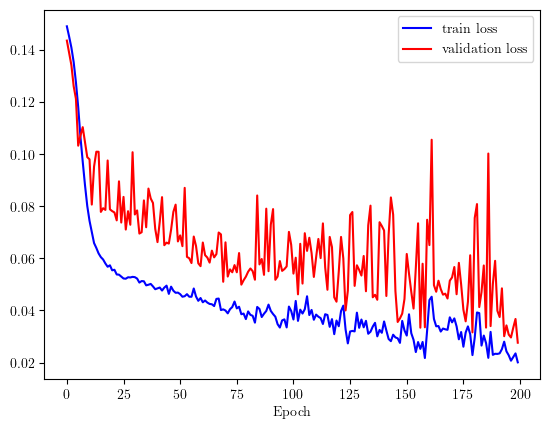

In [10]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

figure = plt.figure()

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

# # Converts the figure to an image
# learning_curve = io.BytesIO()
# figure.savefig(learning_curve, format="png")
# learning_curve.seek(0)

# # Create a PIL image from the image stream
# learning_curve = Image.open(learning_curve)

Text(0.5, 0, 'Epoch')

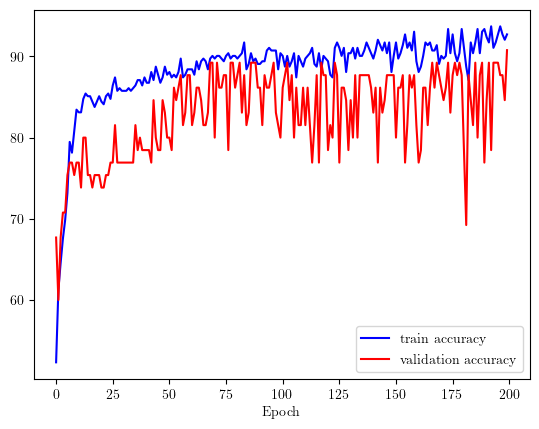

In [11]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [12]:
# Test the model
test_loss, test_accuracy = test(model,
                                device,
                                test_loader,
                                criterion)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

Test loss:  0.01132226942314042
Test accuracy:  93.84615384615384


## Compute and display traversal costs

In [13]:
# Compute the traversal costs from the features of the dataset
costs_df = traversalcost.utils.compute_traversal_costs(
    dataset=params.siamese.DATASET,
    cost_function=model.to(device="cpu"),
    to_tensor=True
)

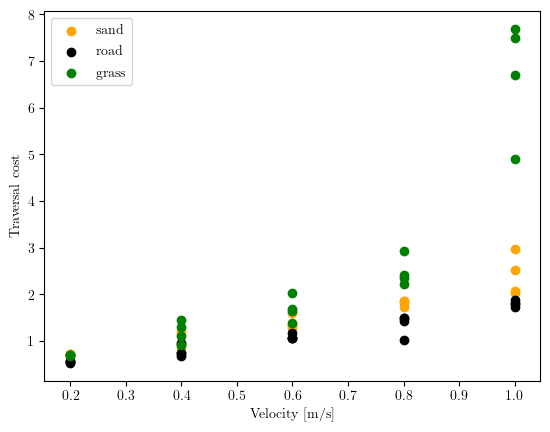

In [14]:
# Display the traversal costs
cost_graph = traversalcost.utils.display_traversal_costs(costs_df)

## Generate a log directory

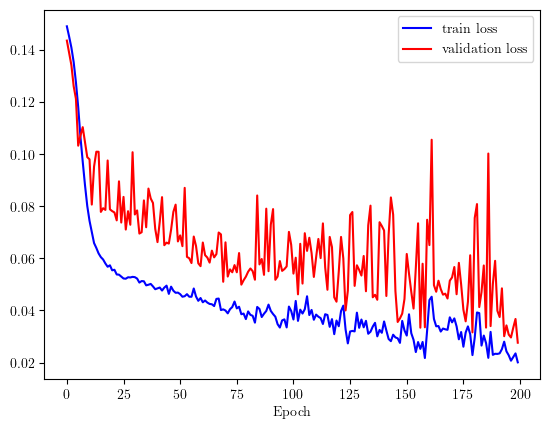

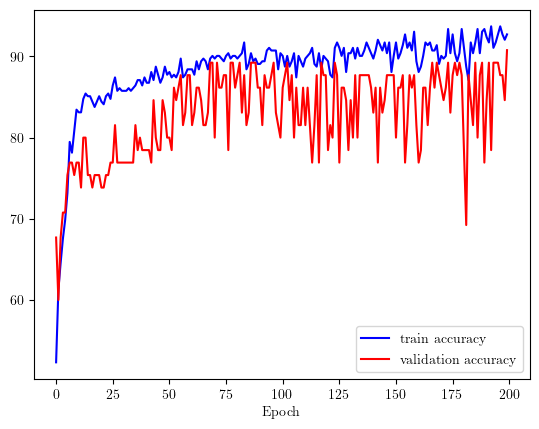

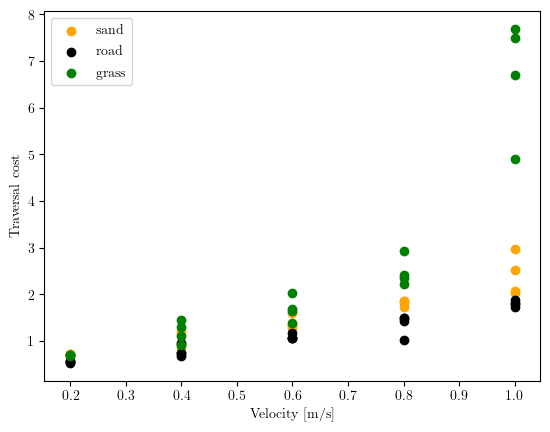

In [15]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.siamese.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.siamese.LOG_DIR:
    results_directory = "logs/_" +\
                        params.siamese.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(dataset_directory=params.siamese.DATASET,
             results_directory=results_directory,
             test_loss=test_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             loss_values=loss_values,
             accuracy_values=accuracy_values)